## Importing the relevant packages


In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.arima_model import ARMA
from scipy.stats.distributions import chi2
import statsmodels.tsa.stattools as sts 
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
sns.set()

## Importing the Data and Pre-processing 

In [2]:
raw_csv_data = pd.read_csv("Index2018.csv") 
df_comp=raw_csv_data.copy()
df_comp.date = pd.to_datetime(df_comp.date, dayfirst = True)
df_comp.set_index("date", inplace=True)
df_comp=df_comp.asfreq('b')
df_comp=df_comp.fillna(method='ffill')

In [3]:
df_comp['market_value']=df_comp.ftse

In [4]:
del df_comp['spx']
del df_comp['dax']
del df_comp['ftse']
del df_comp['nikkei']
size = int(len(df_comp)*0.8)
df, df_test = df_comp.iloc[:size], df_comp.iloc[size:]

## LLR Test

In [5]:
def LLR_test(mod_1, mod_2, DF=1):
    L1 = mod_1.fit().llf
    L2 = mod_2.fit().llf
    LR = (2*(L2-L1))
    p = chi2.sf(LR, DF).round(3)
    return p

In [6]:
# AR Models handles the stationary processes best, thus if AR Models comes from non-stationary processm the AR
# model performs poorly in finding true relationship.
# And to test whether a time series is stationary or not we use the Dickey Fuller or DF test.

## The DF-Test

In [7]:
# We will do the DF test on ftse data
import statsmodels.tsa.stattools as sts
sts.adfuller(df['market_value'])

(-1.9041551418836866,
 0.33010893277028336,
 6,
 5014,
 {'1%': -3.4316548765428174,
  '5%': -2.8621166146845334,
  '10%': -2.5670769326348926},
 54854.15304507557)

In [8]:
# We observe that the test statistic is -1.90 which is more than the 5% value and thus we cannot conclude that
# the time series is stationary, thus we shouldnt rely on AR models for making accurate forecasts.
# To get around this, we try to transform the data set, so it fits the "stationary" assumptions.

## Using Returns

In [9]:
# We need to transform the data into stationary source, one of the ways is to use returns. Returns is computed as
# returns(t)=(p(t)-p(t-1))/p(t-1)*100
df['returns']=df['market_value'].pct_change(1).mul(100)
df=df[1:]
df

/var/folders/ws/jfyqgcz57_374tjld1g6w96m0000gn/T/ipykernel_5413/1034203379.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['returns']=df['market_value'].pct_change(1).mul(100)


,market_value,returns
date,,
1994-01-10,3440.58,-0.156704
1994-01-11,3413.77,-0.779229
1994-01-12,3372.02,-1.222988
1994-01-13,3360.01,-0.356166
1994-01-14,3400.56,1.206842
...,...,...
2013-04-01,6411.74,0.000000
2013-04-02,6490.66,1.230867
2013-04-03,6420.28,-1.084327


In [10]:
sts.adfuller(df['returns'])

(-12.770265719497264,
 7.798058336037375e-24,
 32,
 4987,
 {'1%': -3.431661944885779,
  '5%': -2.8621197374408225,
  '10%': -2.5670785949998973},
 15696.767245697501)

In [11]:
# We can see that the test statistics is -12 which is way less than even 1% critical value, thus we can say that
# the returns data source is stationary and we can apply the AR model data on returns.

## ACF and PACF for Returns

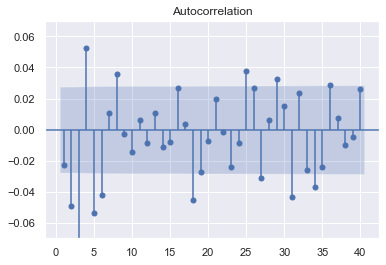

In [12]:
import statsmodels.graphics.tsaplots as sgt
sgt.plot_acf(df['returns'],lags=40,zero=False)
plt.ylim(-0.07,0.07)
plt.show()

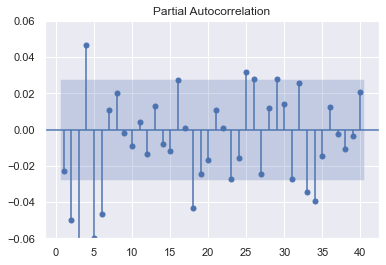

In [13]:
import statsmodels.graphics.tsaplots as sgt
sgt.plot_pacf(df['returns'],lags=40,zero=False,method=('ols'))
plt.ylim(-0.06,0.06)
plt.show()

In [14]:
# With the above we can infer that first few lags are crucial in forecasting. Also we can see that after price
# increase, the lag is of price decrease. Also after first few lags, the old lags are close to zero.

## AR(1) for Returns

In [18]:
from statsmodels.tsa.arima.model import ARIMA
ar1_ret_model=ARIMA(df['returns'],order=(1,0,0)) 
ar1_ret_result=ar1_ret_model.fit()
ar1_ret_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                returns   No. Observations:                 5020
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -7929.749
Date:                Thu, 14 Jul 2022   AIC                          15865.497
Time:                        16:04:52   BIC                          15885.061
Sample:                    01-10-1994   HQIC                         15872.353
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0188      0.016      1.143      0.253      -0.013       0.051
ar.L1         -0.0230      0.009     -2.697      0.007      -0.040      -0.006
sigma2         1.3790      0.014    100.092      0.000       1.352       1.406
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              7872.72
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               2.04   Skew:                            -0.03
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.13
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [19]:
from scipy.stats.distributions import chi2
def LLR_test(mod1,mod2,DF=1):
    res1=mod1.fit().llf
    res2=mod2.fit().llf
    LR=(2*(res2-res1))  #test statistic for this test
    p=chi2.sf(LR,DF)   # here p is p value
    return p.round(3)

## Higher-Lag AR Models for Returns

In [22]:
from statsmodels.tsa.arima.model import ARIMA
ar2_ret_model=ARIMA(df['returns'],order=(2,0,0)) 
ar2_ret_result=ar2_ret_model.fit()
print(ar2_ret_result.summary())
print("LLR Test:",str(LLR_test(ar1_ret_model,ar2_ret_model)))

                               SARIMAX Results                                
Dep. Variable:                returns   No. Observations:                 5020
Model:                 ARIMA(2, 0, 0)   Log Likelihood               -7923.456
Date:                Thu, 14 Jul 2022   AIC                          15854.911
Time:                        16:06:31   BIC                          15880.996
Sample:                    01-10-1994   HQIC                         15864.052
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0188      0.016      1.194      0.233      -0.012       0.050
ar.L1         -0.0242      0.009     -2.799      0.005      -0.041      -0.007
ar.L2         -0.0500      0.008     -6.371      0.0

In [23]:
from statsmodels.tsa.arima.model import ARIMA
ar3_ret_model=ARIMA(df['returns'],order=(3,0,0)) 
ar3_ret_result=ar3_ret_model.fit()
print(ar3_ret_result.summary())
print("LLR Test:",str(LLR_test(ar2_ret_model,ar3_ret_model)))

                               SARIMAX Results                                
Dep. Variable:                returns   No. Observations:                 5020
Model:                 ARIMA(3, 0, 0)   Log Likelihood               -7906.738
Date:                Thu, 14 Jul 2022   AIC                          15823.477
Time:                        16:07:00   BIC                          15856.083
Sample:                    01-10-1994   HQIC                         15834.902
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0189      0.015      1.272      0.203      -0.010       0.048
ar.L1         -0.0283      0.009     -3.199      0.001      -0.046      -0.011
ar.L2         -0.0521      0.008     -6.684      0.0

In [24]:
from statsmodels.tsa.arima.model import ARIMA
ar4_ret_model=ARIMA(df['returns'],order=(4,0,0)) 
ar4_ret_result=ar4_ret_model.fit()
print(ar4_ret_result.summary())
print("LLR Test:",str(LLR_test(ar3_ret_model,ar4_ret_model)))

                               SARIMAX Results                                
Dep. Variable:                returns   No. Observations:                 5020
Model:                 ARIMA(4, 0, 0)   Log Likelihood               -7901.330
Date:                Thu, 14 Jul 2022   AIC                          15814.661
Time:                        16:07:30   BIC                          15853.788
Sample:                    01-10-1994   HQIC                         15828.371
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0188      0.016      1.208      0.227      -0.012       0.049
ar.L1         -0.0245      0.009     -2.770      0.006      -0.042      -0.007
ar.L2         -0.0496      0.008     -6.327      0.0

In [25]:
from statsmodels.tsa.arima.model import ARIMA
ar4_ret_model=ARIMA(df['returns'],order=(4,0,0)) 
ar4_ret_result=ar4_ret_model.fit()
print(ar4_ret_result.summary())
print("LLR Test:",str(LLR_test(ar3_ret_model,ar4_ret_model)))

                               SARIMAX Results                                
Dep. Variable:                returns   No. Observations:                 5020
Model:                 ARIMA(4, 0, 0)   Log Likelihood               -7901.330
Date:                Thu, 14 Jul 2022   AIC                          15814.661
Time:                        16:07:58   BIC                          15853.788
Sample:                    01-10-1994   HQIC                         15828.371
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0188      0.016      1.208      0.227      -0.012       0.049
ar.L1         -0.0245      0.009     -2.770      0.006      -0.042      -0.007
ar.L2         -0.0496      0.008     -6.327      0.0

In [26]:
from statsmodels.tsa.arima.model import ARIMA
ar5_ret_model=ARIMA(df['returns'],order=(5,0,0)) 
ar5_ret_result=ar5_ret_model.fit()
print(ar5_ret_result.summary())
print("LLR Test:",str(LLR_test(ar4_ret_model,ar5_ret_model)))

                               SARIMAX Results                                
Dep. Variable:                returns   No. Observations:                 5020
Model:                 ARIMA(5, 0, 0)   Log Likelihood               -7892.390
Date:                Thu, 14 Jul 2022   AIC                          15798.779
Time:                        16:08:23   BIC                          15844.428
Sample:                    01-10-1994   HQIC                         15814.775
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0189      0.015      1.273      0.203      -0.010       0.048
ar.L1         -0.0217      0.009     -2.396      0.017      -0.040      -0.004
ar.L2         -0.0544      0.008     -6.826      0.0

In [27]:
from statsmodels.tsa.arima.model import ARIMA
ar6_ret_model=ARIMA(df['returns'],order=(6,0,0)) 
ar6_ret_result=ar6_ret_model.fit()
print(ar6_ret_result.summary())
print("LLR Test:",str(LLR_test(ar5_ret_model,ar6_ret_model)))

                               SARIMAX Results                                
Dep. Variable:                returns   No. Observations:                 5020
Model:                 ARIMA(6, 0, 0)   Log Likelihood               -7886.945
Date:                Thu, 14 Jul 2022   AIC                          15789.890
Time:                        16:09:38   BIC                          15842.059
Sample:                    01-10-1994   HQIC                         15808.170
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0189      0.014      1.324      0.186      -0.009       0.047
ar.L1         -0.0245      0.009     -2.640      0.008      -0.043      -0.006
ar.L2         -0.0523      0.008     -6.505      0.0

In [28]:
from statsmodels.tsa.arima.model import ARIMA
ar7_ret_model=ARIMA(df['returns'],order=(7,0,0)) 
ar7_ret_result=ar7_ret_model.fit()
print(ar7_ret_result.summary())
print("LLR Test:",str(LLR_test(ar6_ret_model,ar7_ret_model)))

                               SARIMAX Results                                
Dep. Variable:                returns   No. Observations:                 5020
Model:                 ARIMA(7, 0, 0)   Log Likelihood               -7886.647
Date:                Thu, 14 Jul 2022   AIC                          15791.294
Time:                        16:10:03   BIC                          15849.985
Sample:                    01-10-1994   HQIC                         15811.860
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0189      0.015      1.304      0.192      -0.010       0.047
ar.L1         -0.0240      0.009     -2.579      0.010      -0.042      -0.006
ar.L2         -0.0517      0.008     -6.375      0.0

In [29]:
# Since it fails on AR 7 we will take AR 6 model 

## Normalizing Values

In [ ]:
# So in time series when we say normalize value, it means we convert the sample space to the percentage of first
# value of the set. 

In [31]:
benchmark=df['market_value'].iloc[0]
df['norm_val']=df['market_value'].div(benchmark).mul(100)
sts.adfuller(df['norm_val'])

(-1.892871013267232,
 0.33542220743300866,
 6,
 5013,
 {'1%': -3.431655136974821,
  '5%': -2.8621167297421373,
  '10%': -2.567076993884522},
 19553.90073102193)

In [ ]:
# We note that its not stationary data and thus we try to normalize the returns. It helps us to compare the relative
# profitablity rather than comparing prices.

## Normalized Returns

In [32]:
benchmark=df['returns'].iloc[0]
df['norm_ret']=df['returns'].div(benchmark).mul(100)
sts.adfuller(df['norm_ret'])

(-12.770265719497187,
 7.798058336040004e-24,
 32,
 4987,
 {'1%': -3.431661944885779,
  '5%': -2.8621197374408225,
  '10%': -2.5670785949998973},
 80114.49116124898)

In [ ]:
# This data is stationary process, (since also the source is also stationary, but just double check)

In [ ]:
# Also we can conclude that normalizing does not affect stationarity.

In [33]:
# Now we try to fit AR model on normalized model.
from statsmodels.tsa.arima.model import ARIMA
ar1_model=ARIMA(df['norm_ret'],order=(1,0,0))
ar1_result=ar1_model.fit()
ar1_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:               norm_ret   No. Observations:                 5020
Model:                 ARIMA(1, 0, 0)   Log Likelihood              -40351.743
Date:                Thu, 14 Jul 2022   AIC                          80709.487
Time:                        22:49:45   BIC                          80729.050
Sample:                    01-10-1994   HQIC                         80716.342
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -11.9731     10.476     -1.143      0.253     -32.506       8.560
ar.L1         -0.0230      0.009     -2.697      0.007      -0.040      -0.006
sigma2      5.617e+05   5612.960    100.071      0.000    5.51e+05    5.73e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              7872.68
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               2.04   Skew:                             0.03
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.13
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [34]:
from statsmodels.tsa.arima.model import ARIMA
ar1_model=ARIMA(df['returns'],order=(1,0,0))
ar1_result=ar1_model.fit()
ar1_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                returns   No. Observations:                 5020
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -7929.749
Date:                Thu, 14 Jul 2022   AIC                          15865.497
Time:                        22:50:53   BIC                          15885.061
Sample:                    01-10-1994   HQIC                         15872.353
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0188      0.016      1.143      0.253      -0.013       0.051
ar.L1         -0.0230      0.009     -2.697      0.007      -0.040      -0.006
sigma2         1.3790      0.014    100.092      0.000       1.352       1.406
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              7872.72
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               2.04   Skew:                            -0.03
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.13
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [35]:
from statsmodels.tsa.arima.model import ARIMA
ar2_model=ARIMA(df['norm_ret'],order=(2,0,0))
ar2_result=ar2_model.fit()
ar2_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:               norm_ret   No. Observations:                 5020
Model:                 ARIMA(2, 0, 0)   Log Likelihood              -40345.450
Date:                Thu, 14 Jul 2022   AIC                          80698.901
Time:                        22:51:46   BIC                          80724.986
Sample:                    01-10-1994   HQIC                         80708.041
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -11.9731     10.050     -1.191      0.234     -31.671       7.725
ar.L1         -0.0242      0.009     -2.797      0.005      -0.041      -0.007
ar.L2         -0.0500      0.008     -6.368      0.000      -0.065      -0.035
sigma2      5.603e+05   5628.139     99.561      0.000    5.49e+05    5.71e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):              7730.40
Prob(Q):                              0.77   Prob(JB):                         0.00
Heteroskedasticity (H):               2.03   Skew:                             0.06
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.08
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [36]:
from statsmodels.tsa.arima.model import ARIMA
ar2_model=ARIMA(df['returns'],order=(2,0,0))
ar2_result=ar2_model.fit()
ar2_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                returns   No. Observations:                 5020
Model:                 ARIMA(2, 0, 0)   Log Likelihood               -7923.456
Date:                Thu, 14 Jul 2022   AIC                          15854.911
Time:                        22:52:05   BIC                          15880.996
Sample:                    01-10-1994   HQIC                         15864.052
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0188      0.016      1.194      0.233      -0.012       0.050
ar.L1         -0.0242      0.009     -2.799      0.005      -0.041      -0.007
ar.L2         -0.0500      0.008     -6.371      0.000      -0.065      -0.035
sigma2         1.3756      0.014     99.592      0.000       1.348       1.403
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):              7730.29
Prob(Q):                              0.77   Prob(JB):                         0.00
Heteroskedasticity (H):               2.03   Skew:                            -0.06
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.08
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
# We observed that the the AR model coefficients are same (except for constants) for both the normalized and 
# not normalized data and thus we can conclude that normalization does not impact the AR model.

## Analysing the Residuals

In [38]:
# We found that ar6 works best for our data. 
# Now we will be analyzing the residual error, examine its statistics and test it for stationarity. 
# Ideally residuals should be random walk and thus be stationary.
# We can use .resid attribute to find the residuals

In [40]:
ar6_model=ARIMA(df['returns'],order=(6,0,0))
ar6_result=ar6_model.fit()
df['returns_resid']=ar6_result.resid

In [41]:
df['returns_resid'].mean()

-4.853041936608605e-05

In [42]:
df['returns_resid'].var()

1.355980212871521

In [43]:
# for returns the variance is also low

In [45]:
import statsmodels.tsa.stattools as sts 
sts.adfuller(df['returns_resid'])

(-70.78411836200789,
 0.0,
 0,
 5019,
 {'1%': -3.4316535759402753,
  '5%': -2.8621160400844468,
  '10%': -2.567076626752987},
 15692.570807333226)

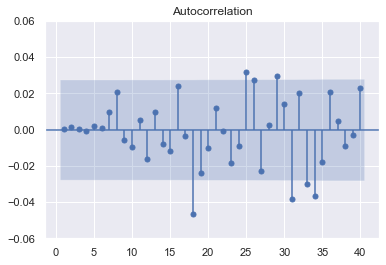

In [46]:
import statsmodels.graphics.tsaplots as sgt
sgt.plot_acf(df['returns_resid'],lags=40,zero=False)
plt.ylim(-0.06,0.06)
plt.show()

(-20.0, 20.0)

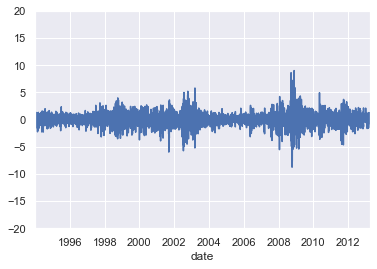

In [49]:
df['returns_resid'].plot()
plt.ylim(-20,20)